# WELCOME !!!!

## This Notebook will serve as the second workshop on how to build a classification model by leveraging Bert with the K-train library. I encourage you to read this link if you want to learn more about how Bert works under the hood: https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270       
## I will use the dataset that I've annotated, twitter_homophobia.csv, and we'll build a binary classifier.
## This notebook is split into 4 sections:
### PART 1: GETTING THE DATA AND READING IT
### PART 2: VISUALISING THE DATA AND PERFORMING SOME EDA
### PART 3: PREPROCESSING THE DATA SO THAT IT CAN BE USED IN OUR MODEL
### PART 4: BUILDING AND VALIDATING OUR MODEL

In [31]:
import tensorflow as tf
import os
try:
    import ktrain
except:
    !pip install ktrain
    import ktrain
from ktrain import text
from ktrain.text import texts_from_df
from keras.preprocessing.text import Tokenizer
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import nltk
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
from string import punctuation, digits
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import itertools
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# PART 1: THE DATA

### Getting and reading the data using pandas

In [32]:
data = pd.read_csv("twitter_homophobia.csv")

In [33]:
data.head()

,id,text,created_at,user_id,label,Comments
0,23,@nopsito_off @cpastibo @Mattotf1 ta pas la ref...,Mon Dec 26 18:53:52 +0000 2022,1596185810503667713,Homophobia,NaN
1,22,"mais les meuf la qui disent ""oue c ma came"" et...",Mon Dec 26 18:54:30 +0000 2022,1520921717920706561,Homophobia,NaN
2,21,@kc667ekip Ils nous cassent les couilles les p...,Mon Dec 26 18:55:29 +0000 2022,1562767614937812993,Homophobia,NaN
3,20,@dorobo_lala @evxszn @kujantho @nai_inno C’est...,Mon Dec 26 19:00:01 +0000 2022,1539657588584898562,Homophobia,NaN
4,19,lesbienne 1 https://t.co/5bS7KXQqKU,Mon Dec 26 19:01:26 +0000 2022,1283153294446202887,Homophobia,NaN


In [34]:
data.shape

(2000, 6)

### From this simple analysis, we can see that we have 2000 tweets in  data. We also have some columns that we will be dropping since they are not useful for predicting if a text is homophobic or not.

In [35]:
data.isnull().sum()

id               0
text             0
created_at       0
user_id          0
label            2
Comments      2000
dtype: int64

In [36]:
data.loc[0]['text']

'@nopsito_off @cpastibo @Mattotf1 ta pas la ref c pr sa g rien contre les pd tkt'

# PART 2: VISUALIZING THE DATA AND EDA

In [37]:
data

,id,text,created_at,user_id,label,Comments
0,23,@nopsito_off @cpastibo @Mattotf1 ta pas la ref...,Mon Dec 26 18:53:52 +0000 2022,1596185810503667713,Homophobia,NaN
1,22,"mais les meuf la qui disent ""oue c ma came"" et...",Mon Dec 26 18:54:30 +0000 2022,1520921717920706561,Homophobia,NaN
2,21,@kc667ekip Ils nous cassent les couilles les p...,Mon Dec 26 18:55:29 +0000 2022,1562767614937812993,Homophobia,NaN
3,20,@dorobo_lala @evxszn @kujantho @nai_inno C’est...,Mon Dec 26 19:00:01 +0000 2022,1539657588584898562,Homophobia,NaN
4,19,lesbienne 1 https://t.co/5bS7KXQqKU,Mon Dec 26 19:01:26 +0000 2022,1283153294446202887,Homophobia,NaN
...,...,...,...,...,...,...
1995,1996,@PANPANSKSK_ hb mon pd préféré,Sat Dec 24 00:10:20 +0000 2022,1408155151026819075,Homophobia,NaN
1996,1997,@YouYouvens @ActuFoot_ Il veut quoi le pd ?,Sat Dec 24 00:06:56 +0000 2022,1061108174,Homophobia,NaN
1997,1998,@koopstwt Voeu/PD/Guérison euh ?,Fri Dec 23 23:57:56 +0000 2022,1161268713842204672,NaN,NaN
1998,1999,Mais la partie 4 de Paradise PD ils sont allés...,Fri Dec 23 23:57:26 +0000 2022,1259295319,None,NaN


In [38]:
data['label'].value_counts()

Homophobia    1185
None           813
Name: label, dtype: int64

([<matplotlib.patches.Wedge at 0x7f2e1f3fa640>,
 [Text(-0.3171401229221063, 1.0532911005192018, 'Homophobia'),
  Text(0.31714012292210664, -1.0532911005192018, 'None')],
 [Text(-0.17298552159387615, 0.5745224184650192, '59.309%'),
  Text(0.1729855215938763, -0.5745224184650191, '40.691%')])

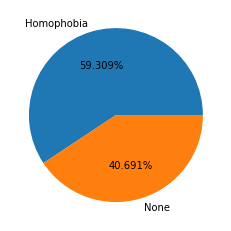

In [39]:
plt.pie(data['label'].value_counts(), 
        labels=["Homophobia","None"],
       autopct="%.3f%%")

<BarContainer object of 2 artists>

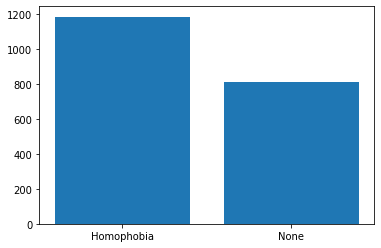

In [40]:
plt.bar(x=["Homophobia","None"], 
        height=data['label'].value_counts())

### We can see that we have a roughly balanced dataset, so we don't really need to do any big data manipulation. We have about 60% of the texts that are homophobic, and 40% that aren't. We will see later how to balance this data so that we have an even number of tweets.
### Now, we need to clean the data by getting read of the stopwords that are commonly used in french, as well as tokenizing and lemmatizing our texts.

# PART 3: CLEANING THE DATA

In [41]:
def clean_text(data):
    """
    input: data: a dataframe containing texts to be cleaned
    return: the same dataframe with an added column of clean text
    """
    clean_data = data.copy()
    clean_data = clean_data[['text', 'label']]
    stop_words = stopwords.words('french')
    clean_text = []
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()

    for idx in range(len(data)):
        text = clean_data['text'][idx]
        label = clean_data['label'][idx]
        text_lowercase = text.lower()
        text_no_stopwords = " ".join([word for word in text_lowercase.split() if word not in (stop_words)])
        text_tokenized = tokenizer.tokenize(text_no_stopwords)
        text_lemmatized = [lemmatizer.lemmatize(token) for token in text_tokenized]
        clean_text = ' '.join(text_lemmatized)
        clean_data['text'][idx] = clean_text
    return clean_data

### The above function does the following: it reads in a dataframe, and selects the 'text' column. It will lemmatize a word if the word is not a stopword or a punctuation. This is useful because otherwise we would have a lot of superfluous, and ultimately useless, data inside our dataset. We then create a new Dataframe to avoid confusions with the trainining dataset. 

In [42]:
clean_data = clean_text(data)

In [43]:
clean_data

,text,label
0,nopsito_off cpastibo mattotf1 ref pr g rien co...,Homophobia
1,meuf disent oue came etc wallah très lesbienne...,Homophobia
2,kc667ekip cassent couilles pd,Homophobia
3,dorobo_lala evxszn kujantho nai_inno c est vra...,Homophobia
4,lesbienne 1 http t co 5bs7kxqqku,Homophobia
...,...,...
1995,panpansksk_ hb pd préféré,Homophobia
1996,youyouvens actufoot_ veut quoi pd,Homophobia
1997,koopstwt voeu pd guérison euh,NaN
1998,partie 4 paradise pd allés vraiment loin j ai mot,None


### We can drop the 'text' column since we created a new one with the clean text in it, we can also drop the 'keyword' and 'location' column as well since we will classify based only on the contents of a text.

In [44]:
clean_data['label'].value_counts()

Homophobia    1185
None           813
Name: label, dtype: int64

### Since we don't have a fully balanced dataset, we are going to keep only 800 samples from each category. for the real model, we would need more data, but since I'm using a small dataset I don't have a choice, so 800 will do fine :)      
### We then merge each dataframe inside a new dataframe that we will use to build our model.

In [45]:
sample_amount = 800

target = clean_data[clean_data['label']=='Homophobia'].sample(n=sample_amount)
non_target = clean_data[clean_data['label']=='None'].sample(n=sample_amount)

In [46]:
target.head()

,text,label
1041,apkaa__ bouyaaa217 _befootball aime juste fami...,Homophobia
967,_befootball fort pd,Homophobia
1475,j entre maison oncle dit j ai coupe pédé vanil...,Homophobia
1906,_confessfantasm va finir lesbienne,Homophobia
415,askip s il change couche aussi c est pd http t...,Homophobia


In [47]:
non_target.head()

,text,label
1655,littérature lesbienne déferle librairies trouv...,None
116,litteul_kevin heubeu31 papidou07 patrickferstl...,None
612,lesbienne,None
1595,maxime cochard donne envie d être lesbienne,None
1529,ew j ai fait connaissance d une fille vacances...,None


In [48]:
data = pd.concat([target, non_target])
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)
data.head()

,text,label
0,apkaa__ bouyaaa217 _befootball aime juste fami...,Homophobia
1,_befootball fort pd,Homophobia
2,j entre maison oncle dit j ai coupe pédé vanil...,Homophobia
3,_confessfantasm va finir lesbienne,Homophobia
4,askip s il change couche aussi c est pd http t...,Homophobia


### We have our final dataset that we will use to train our model :D 

# PART 4: MODEL BUILDING AND EVALUATION

### I decided to use a Distilbert model for the following reasons: it's really easy to use and is well optimized, so the training time is quite fast. It is also easily explainable and has a few APIs that makes predictions easy to make and interpret, and finally the wrapper inside ktrain is really convenient. I woudl strongly encourage you to read this from the about Distilbert on the hugging face page: https://huggingface.co/docs/transformers/model_doc/distilbert

In [49]:
target_names = ['None', 'Homophobia']

### We load the model, then do a train/test split. We choose the distilbert processing method

In [50]:
transformer = text.Transformer('distilbert-base-uncased', 
                              maxlen=512,
                              class_names=target_names)

### HYPERPARAMETERS: I've chosen to use 200 for the maxfeatures and a maxlen of 512 as it really speeds up the training process while not losing much in accuracy. We then call the model with a batch size of 16 to speed up even more the training process (a bigger batch size in this case led to a decrease in accuracy in the final model)

In [51]:
train, val, preprocess = texts_from_df(data, 'text',
                                      label_columns=['label'],
                                      val_df=None,
                                      max_features=200,
                                      maxlen=512,
                                      val_pct=0.1,
                                      ngram_range=1,
                                      preprocess_mode='distilbert',
                                      verbose=1)

['Homophobia', 'None']
      Homophobia  None
1507         0.0   1.0
883          0.0   1.0
15           1.0   0.0
33           1.0   0.0
462          1.0   0.0
['Homophobia', 'None']
      Homophobia  None
45           1.0   0.0
1541         0.0   1.0
404          1.0   0.0
562          1.0   0.0
1488         0.0   1.0
preprocessing train...
language: fr
train sequence lengths:
	mean : 11
	95percentile : 21
	99percentile : 24


Is Multi-Label? False
preprocessing test...
language: fr
test sequence lengths:
	mean : 12
	95percentile : 21
	99percentile : 23


In [52]:
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train,
                            val_data=val, batch_size=16) 

In [53]:
learner.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
90/90 [==============================] - 93s 957ms/step - loss: 0.6905 - accuracy: 0.5451
Epoch 2/6
90/90 [==============================] - 86s 956ms/step - loss: 0.5788 - accuracy: 0.7347
Epoch 3/6
90/90 [==============================] - 86s 953ms/step - loss: 0.5139 - accuracy: 0.7785
Epoch 4/6
90/90 [==============================] - 86s 951ms/step - loss: 0.7096 - accuracy: 0.5792
Epoch 5/6
90/90 [==============================] - 63s 697ms/step - loss: 74.6693 - accuracy: 0.4953


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


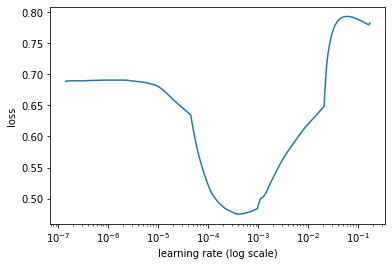

In [54]:
learner.lr_plot()

## early stopping here is used to stop the training if the performance drops, so as to gain time. We will only train the model for 6 epochs, as the goal of this workshop is not to build a full state-of-the art app, but rather just an introduction to NLP classification.

In [55]:
history=learner.autofit(1e-4,checkpoint_folder='checkpoint',epochs=11, 
                        early_stopping=True) 



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/11
90/90 [==============================] - 99s 1s/step - loss: 0.5274 - accuracy: 0.7514 - val_loss: 0.4462 - val_accuracy: 0.8250
Epoch 2/11
90/90 [==============================] - 89s 986ms/step - loss: 0.3977 - accuracy: 0.8396 - val_loss: 0.4343 - val_accuracy: 0.8250
Epoch 3/11
90/90 [==============================] - 89s 984ms/step - loss: 0.3184 - accuracy: 0.8729 - val_loss: 0.4553 - val_accuracy: 0.8438
Epoch 3: early stopping
Weights from best epoch have been loaded into model.


In [56]:
validation = learner.validate(val_data=val, print_report=True)

5/5 [==============================] - 2s 92ms/step
              precision    recall  f1-score   support

           0       0.86      0.77      0.81        78
           1       0.80      0.88      0.84        82

    accuracy                           0.82       160
   macro avg       0.83      0.82      0.82       160
weighted avg       0.83      0.82      0.82       160



## From the validation, we can see that we have really good metrics. Our accuracy and f1-score is 80%, which is great considering the relatively small dataset and training time !

## After training and validating our model, we get the predictions and create a frame that looks like the one provided.

In [57]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

In [68]:
test_data = clean_data.head(25)
test_data

,text,label
0,nopsito_off cpastibo mattotf1 ref pr g rien co...,Homophobia
1,meuf disent oue came etc wallah très lesbienne...,Homophobia
2,kc667ekip cassent couilles pd,Homophobia
3,dorobo_lala evxszn kujantho nai_inno c est vra...,Homophobia
4,lesbienne 1 http t co 5bs7kxqqku,Homophobia
5,lesbienne 2 http t co 57igjlcsvd,Homophobia
6,el_you97 tozemouk infosom_ eldebate bah quand ...,None
7,cvmacedog réveillon pede né,Homophobia
8,a compte fake gar m ajoute dpuis talheur si jv...,Homophobia
9,lilyynelson vui veux quand être lesbienne clea...,None


In [69]:
for i in range(len(test_data)):
    text = test_data.loc[i]['text']
    probs = predictor.predict(text, return_proba = True)
    if probs[0] >= 0.5:
        test_data.loc[i,'target'] = 'Homophobia'
    else:
        test_data.loc[i,'target'] = 'None'

1/1 [==============================] - 0s 64ms/step


In [70]:
test_data

,text,label,target
0,nopsito_off cpastibo mattotf1 ref pr g rien co...,Homophobia,Homophobia
1,meuf disent oue came etc wallah très lesbienne...,Homophobia,None
2,kc667ekip cassent couilles pd,Homophobia,Homophobia
3,dorobo_lala evxszn kujantho nai_inno c est vra...,Homophobia,None
4,lesbienne 1 http t co 5bs7kxqqku,Homophobia,None
5,lesbienne 2 http t co 57igjlcsvd,Homophobia,None
6,el_you97 tozemouk infosom_ eldebate bah quand ...,None,None
7,cvmacedog réveillon pede né,Homophobia,Homophobia
8,a compte fake gar m ajoute dpuis talheur si jv...,Homophobia,Homophobia
9,lilyynelson vui veux quand être lesbienne clea...,None,None


# Reading Materials: 

## https://medium.com/distributed-computing-with-ray/hyperparameter-optimization-for-transformers-a-guide-c4e32c6c989b 
## https://amaiya.github.io/ktrain/index.html
## https://towardsdatascience.com/transformers-89034557de14